In [1]:
%load_ext autoreload
%autoreload 2
from agent_configs import make_agent
from training import run_training, train_reps, train_or_load_condition
from eval_funcs import avg_stats, eval_holdout_stats, eval_total_cert_stats

def gauss(data, filters=[(0,100,1.0)]):
    from scipy.ndimage.filters import gaussian_filter1d
    for (st, en, sig) in filters:
        if(sig == 0): continue
        l = len(data) 
        en = max(en,l) if en != -1 else en
        if(l > st):
            data[st:en] = gaussian_filter1d(data[st:en],sigma=sig)
    return data

CRE Cache Lives Here:  /home/danny/.cache/cre/cre_cache


/home/danny/env/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


unicode_type


In [2]:
mc_conditions = {
    ("mc", "stand", False) : {"n_prob": 100, "reps" : 40},
    ("mc", "decision_tree", False) : {"n_prob": 100, "reps" : 40},
    ("mc", "random_forest", False) : {"n_prob": 100, "reps" : 40},
    ("mc", "xg_boost", False) : {"n_prob": 100, "reps" : 40},
    
    #("mc", "stand-relaxed", False) : {"n_prob": 100, "reps" : 6},
    #("mc", "stand", True) : {"n_prob": 100, "reps" : 1},
}

mc_conditions_active = {
    ("mc", "stand", False, True) : {"n_prob": 100, "reps" : 40},
    #("mc", "decision_tree", False, True) : {"n_prob": 100, "reps" : 20},
    ("mc", "random_forest", False, True) : {"n_prob": 100, "reps" : 40},
    ("mc", "xg_boost", False, True) : {"n_prob": 100, "reps" : 40},
    
    #("mc", "stand-relaxed", False) : {"n_prob": 100, "reps" : 6},
    #("mc", "stand", True) : {"n_prob": 100, "reps" : 1},
}

frac_conditions = {
    ("frac", "stand", False) : {"n_prob": 100, "reps" : 40},
    ("frac", "decision_tree", False) : {"n_prob": 100, "reps" : 40},
    ("frac", "random_forest", False) : {"n_prob": 100, "reps" : 40},
    ("frac", "xg_boost", False) : {"n_prob": 100, "reps" : 40},
}

frac_conditions_active = {
    ("frac", "stand", False, True) : {"n_prob": 100, "reps" : 40},
    #("frac", "decision_tree", False, True) : {"n_prob": 100, "reps" : 20},
    ("frac", "random_forest", False, True) : {"n_prob": 100, "reps" : 40},
    ("frac", "xg_boost", False, True) : {"n_prob": 100, "reps" : 40},
}

stat_cache = {}
def stats_by_cond(conditions, grp, stat_name, kind="avg"):
    out = {}
    for tup, kwargs in conditions.items():
        if(tup not in stat_cache):
            ret = train_or_load_condition(*tup, 
                    n_prob=kwargs.get("n_probs", 100), reps=kwargs.get("reps", 3))
            stat_cache[tup] = ret
            
        ret = stat_cache[tup]
        out[(tup[1], tup[2])] = ret[grp][stat_name][kind]
    return out

def stats_at_index_by_cond(conditions, grp, stat_name, index, kind="avg"):
    stats = stats_by_cond(conditions, grp, stat_name, kind)
    stats = {k:v[index] for k,v in stats.items()}
    return stats
    

def print_stat(name, val, prec=2):
    print(f"{name}: {val*100:.{prec}f}%")

def print_stats(conditions, grp, name, title=None, big_better=True, index=None):
    title = title if title else name
    if(index is None):
        d = stats_by_cond(conditions, grp, name)
    else:
        d = stats_at_index_by_cond(conditions, grp, name, index=index)
    print(f"{title}:")
    best_ind = np.argmax([d if big_better else -d for d in d.values()])
    for i, (cond, val) in enumerate(d.items()):
        when, proc = cond
        bold = best_ind == i
        pre = "\033[1m" if bold else ""
        post = "\033[0m" if bold else ""
        ps = "-proc" if proc else ""
        print(f"  {when}{ps}: {pre}{val*100:.2f}%{post}")

        
  

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


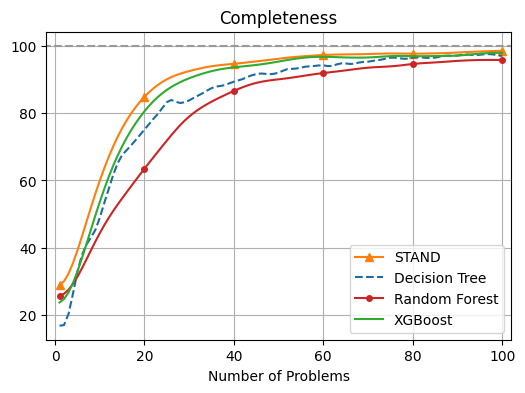

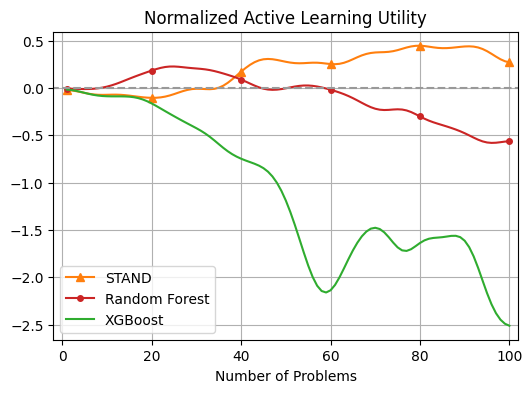

In [34]:
        
import matplotlib.pyplot as plt
import numpy as np

# Replace [0] darken old blue #1f77b4 (For Tritanopia blue-green)
# Replace [2] lighten old green #2ca02c (For Deuteranopia red-green)
# Replace [3] darken old red #d62728 (For Deuteranopia red-green)q
colors = ['#1c6ca3', '#ff7f0e', '#2fac2f', '#cb2525', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

cond_colors = {
    "decision_tree" : colors[0],
    "random_forest" : colors[3],
    "xg_boost" : colors[2],
    "stand" : colors[1], # Orange
}

cond_labels = {
    "decision_tree" : "Decision Tree",
    "random_forest" : "Random Forest",
    "xg_boost" : "XGBoost",
    "stand" : "STAND",
}

cond_marker_props = {
    "stand" : {"marker" : "^", "markersize" : 6, "markevery" : [0,19,39,59,79, -1]},
    "random_forest" : {"marker" : ".", "markersize" : 8, "markevery" : [0,19,39,59,79, -1]},
    "decision_tree" : {"linestyle" : "--"},
}

def plot_stat(conditions, stat, grp=1, title=None, skip=[], y_lim=None, h_line=None,
              y_label=None, x_label="Number of Problems", save_name=None):
    plt.figure(figsize=(6,4))
    
    title = title if title else stat
    
    stats = stats_by_cond(conditions, grp, stat)
    for ((when, has_proc), curve), (cond, config) in zip(stats.items(), conditions.items()):
        #when, has_proc = cond 
        if(when in skip):
            continue
        print(conditions[cond])
        label = conditions[cond].get('label',cond_labels.get(when, when))
        color = conditions[cond].get('color',cond_colors.get(when, "grey"))
        marker_props = conditions[cond].get('marker_props',cond_marker_props.get(when, {}))
        plt.plot(np.arange(1,len(curve)+1), gauss(curve*100), color=color, 
                 label=label, **marker_props)
    plt.grid()
    plt.title(title)
    plt.legend()    
    if(h_line is not None): plt.hlines(h_line, -10,110, linestyle='--', color="#999")
    if(y_lim): plt.ylim(*y_lim)
    plt.xlim(-2, 102)
    if(x_label): plt.xlabel(x_label)
    if(y_label): plt.ylabel(y_label)
    
    if(save_name): 
        plt.savefig(f"plots/{save_name}.png", bbox_inches='tight')
        plt.savefig(f"plots/{save_name}.pdf", bbox_inches='tight', format='pdf')
    plt.show()

def plot_diff(conditions, conds_active, stat, grp=1, title=None, y_lim=None, h_line=None,
              y_label=None, x_label="Number of Problems", save_name=None):
    plt.figure(figsize=(6,4))
    
    title = title if title else stat
    conds = {(a,b,c):conditions[(a,b,c)] for (a,b,c,d) in conds_active}
    stats = stats_by_cond(conds, grp, stat)
    stats_conds  = stats_by_cond(conds_active, grp, stat)
    for (c0, curve0), (c1, curve1) in zip(stats.items(), stats_conds.items()):
        when, has_proc = c0
        curve0 = gauss(curve0)
        curve1 = gauss(curve1)
        diff = ((curve1-curve0)/(1-curve0))
        plt.plot(np.arange(1,len(diff)+1), diff, color=cond_colors.get(when, "grey"), 
                 label=cond_labels.get(when, when), **cond_marker_props.get(when, {}))
    plt.grid()
    plt.title(title)
    plt.legend()
    if(h_line is not None): plt.hlines(h_line, -10,110, linestyle='--', color="#999")
    plt.xlim(-2, 102)
    if(y_lim): plt.ylim(*y_lim)
    if(x_label): plt.xlabel(x_label)
    if(y_label): plt.ylabel(y_label)
   

    if(save_name): 
        plt.savefig(f"plots/{save_name}.png", bbox_inches='tight')
        plt.savefig(f"plots/{save_name}.pdf", bbox_inches='tight', format='pdf')
    plt.show()
        
plot_stat(mc_conditions, "completeness", 0, "Completeness", h_line=100)    
#plot_stat(mc_conditions_active, "completeness", 0, "Completeness") 
plot_diff(mc_conditions, mc_conditions_active, "completeness", 0, "Normalized Active Learning Utility", h_line=0) 

## MC Addition Total Stats

In [35]:
print_stats(mc_conditions, 0, "completeness", "Completeness prob=20", True, index=19)
print_stats(mc_conditions, 0, "completeness", "Completeness prob=50", True, index=49)
print_stats(mc_conditions, 0, "completeness", "Completeness prob=100", True, index=99)
print()
print_stats(mc_conditions, 1, "total_prod_monot", "Total Productive Monotonicity")
print_stats(mc_conditions, 1, "total_error_reocc", "Total Error Reoccurance", False)
print_stats(mc_conditions, 1, "total_FN_reocc", "Total Comission Reoccurance", False)
print_stats(mc_conditions, 1, "total_FP_reocc", "Total Omission Reoccurance", False)
print()
print_stats(mc_conditions, 1, ("total_precision",.9), "Total Precision @90%", True)
print_stats(mc_conditions, 1, ("total_precision",1.0), "Total Precision @100%", True)

Completeness prob=20:
  stand: 84.84%
  decision_tree: 75.75%
  random_forest: 63.49%
  xg_boost: 80.53%
Completeness prob=50:
  stand: 96.13%
  decision_tree: 91.86%
  random_forest: 90.02%
  xg_boost: 95.30%
Completeness prob=100:
  stand: 98.48%
  decision_tree: 96.97%
  random_forest: 95.77%
  xg_boost: 97.91%

Total Productive Monotonicity:
  stand: 56.74%
  decision_tree: 55.40%
  random_forest: 51.26%
  xg_boost: 52.58%
Total Error Reoccurance:
  stand: 0.53%
  decision_tree: 0.38%
  random_forest: 1.28%
  xg_boost: 0.74%
Total Comission Reoccurance:
  stand: 0.86%
  decision_tree: 1.48%
  random_forest: 0.98%
  xg_boost: 0.81%
Total Omission Reoccurance:
  stand: 0.43%
  decision_tree: 0.00%
  random_forest: 1.37%
  xg_boost: 0.73%

Total Precision @90%:
  stand: 93.19%
  decision_tree: 86.40%
  random_forest: 97.15%
  xg_boost: 98.35%
Total Precision @100%:
  stand: 99.81%
  decision_tree: 86.40%
  random_forest: 94.79%
  xg_boost: 100.00%


## Fractions Total Stats

In [36]:
print_stats(frac_conditions, 0, "completeness", "Completeness prob=20", True, index=19)
print_stats(frac_conditions, 0, "completeness", "Completeness prob=50", True, index=49)
print_stats(frac_conditions, 0, "completeness", "Completeness prob=100", True, index=99)
print()
print_stats(frac_conditions, 1, "total_prod_monot", "Total Productive Monotonicity")
print_stats(frac_conditions, 1, "total_error_reocc", "Total Error Reoccurance", False)
print_stats(frac_conditions, 1, "total_FN_reocc", "Total Comission Reoccurance", False)
print_stats(frac_conditions, 1, "total_FP_reocc", "Total Omission Reoccurance", False)
print()
print_stats(frac_conditions, 1, ("total_precision",.9), "Total Precision @90%", True)
print_stats(frac_conditions, 1, ("total_precision",1.0), "Total Precision @100%", True)

Completeness prob=20:
  stand: 98.59%
  decision_tree: 88.15%
  random_forest: 87.26%
  xg_boost: 81.58%
Completeness prob=50:
  stand: 99.90%
  decision_tree: 97.24%
  random_forest: 97.40%
  xg_boost: 97.47%
Completeness prob=100:
  stand: 99.99%
  decision_tree: 99.88%
  random_forest: 98.96%
  xg_boost: 97.11%

Total Productive Monotonicity:
  stand: 79.61%
  decision_tree: 58.71%
  random_forest: 51.81%
  xg_boost: 48.71%
Total Error Reoccurance:
  stand: 0.05%
  decision_tree: 0.06%
  random_forest: 0.41%
  xg_boost: 0.81%
Total Comission Reoccurance:
  stand: 0.08%
  decision_tree: 0.23%
  random_forest: 0.07%
  xg_boost: 0.34%
Total Omission Reoccurance:
  stand: 0.04%
  decision_tree: 0.00%
  random_forest: 0.52%
  xg_boost: 0.96%

Total Precision @90%:
  stand: 95.70%
  decision_tree: 90.16%
  random_forest: 95.19%
  xg_boost: 99.39%
Total Precision @100%:
  stand: 100.00%
  decision_tree: 90.16%
  random_forest: 93.72%
  xg_boost: 100.00%


{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


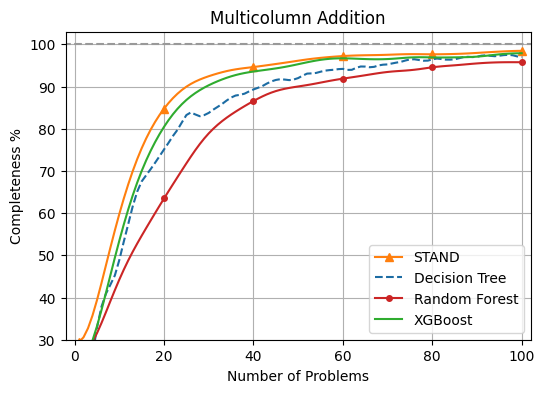

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


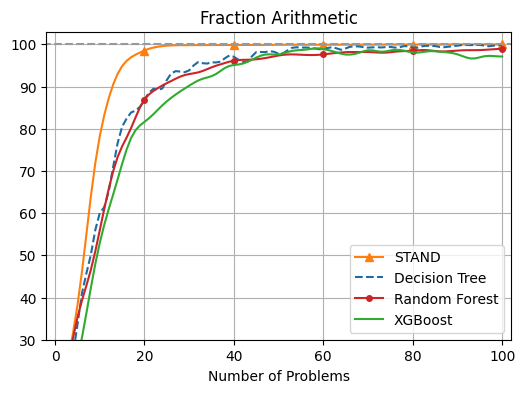

In [37]:
# Completeness
plot_stat(mc_conditions, "completeness", 0, "Multicolumn Addition", y_lim=(30,103), h_line=100, save_name="mc_compl", y_label="Completeness %")
plot_stat(frac_conditions, "completeness", 0, "Fraction Arithmetic", y_lim=(30,103), h_line=100, save_name="frac_compl")

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


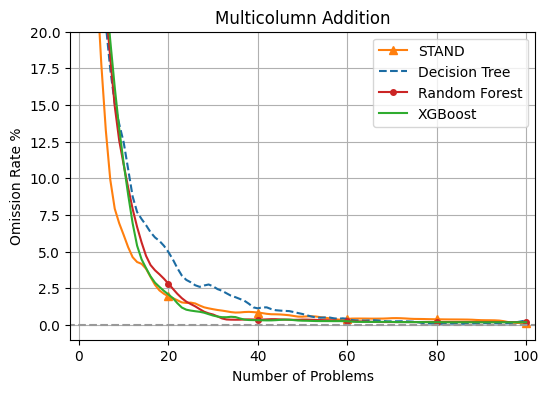

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


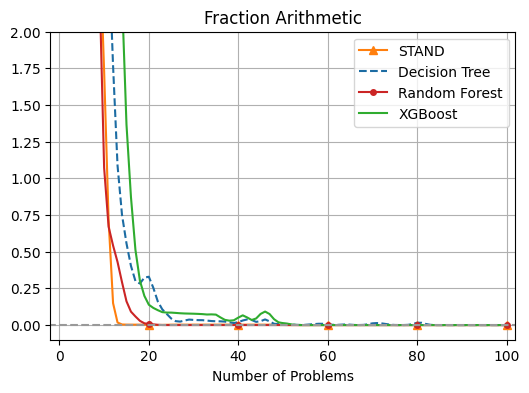

In [38]:
# Omission Rate
plot_stat(mc_conditions, "omission_rate", 0, "Multicolumn Addition", y_lim=(-1,20), h_line=0, save_name="mc_oms", y_label="Omission Rate %")
plot_stat(frac_conditions, "omission_rate", 0, "Fraction Arithmetic", y_lim=(-.1,2), h_line=0, save_name="frac_oms")

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


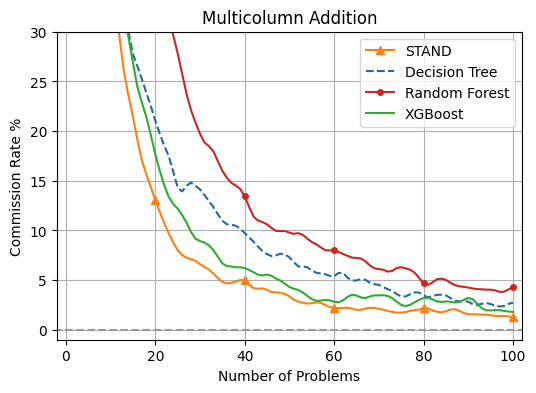

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


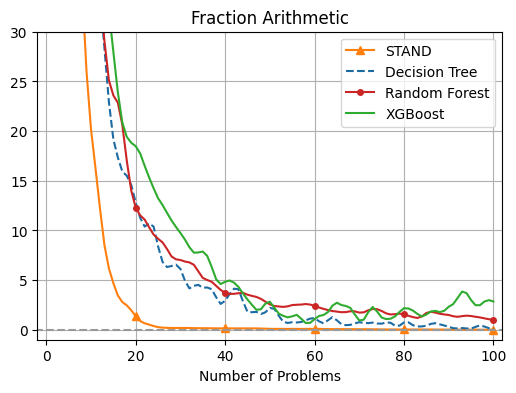

In [39]:
# Comission Rate
plot_stat(mc_conditions, "comission_rate", 0, "Multicolumn Addition", y_lim=(-1,30), h_line=0, save_name="mc_coms", y_label="Commission Rate %")
plot_stat(frac_conditions, "comission_rate", 0, "Fraction Arithmetic", y_lim=(-1,30), h_line=0, save_name="frac_coms")

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


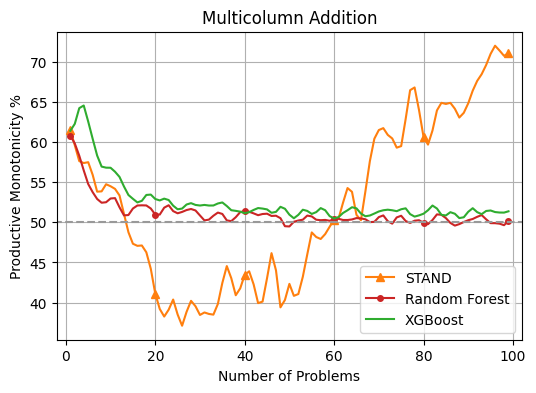

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


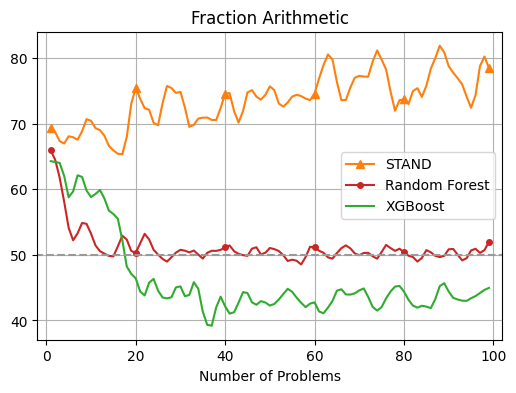

In [40]:
# Productive Monotonicity
plot_stat(mc_conditions, "prod_monot", 1, "Multicolumn Addition", skip=['decision_tree'], h_line=50, save_name="mc_prod_mont", y_label="Productive Monotonicity %")
plot_stat(frac_conditions, "prod_monot", 1, "Fraction Arithmetic", skip=['decision_tree'], h_line=50, save_name="frac_prod_mont")

/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


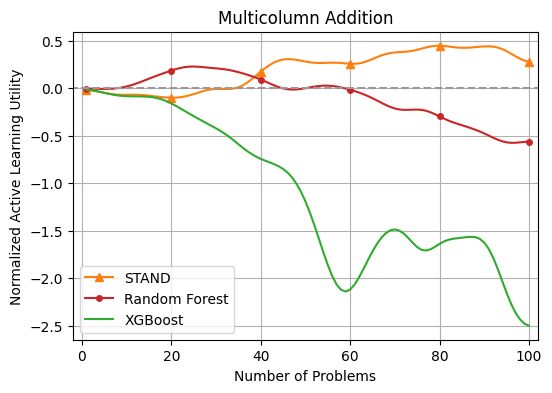

/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


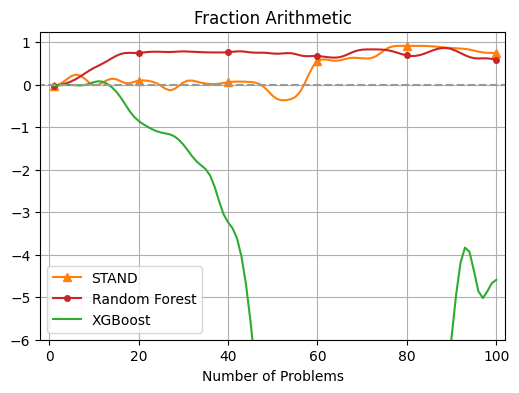

In [41]:
# Normalized Active Learning Utility
plot_diff(mc_conditions, mc_conditions_active, "completeness", 0, "Multicolumn Addition", h_line=0, save_name="mc_actl_util", y_label="Normalized Active Learning Utility") 
plot_diff(frac_conditions, frac_conditions_active, "completeness", 0, "Fraction Arithmetic", h_line=0, y_lim=(-6,1.25), save_name="frac_actl_util") 

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40, 'label': 'STAND + HTN Induction', 'color': '#17becf', 'marker_props': {'marker': 's', 'markersize': 4, 'markevery': [0, 19, 39, 59, 79, -1]}}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


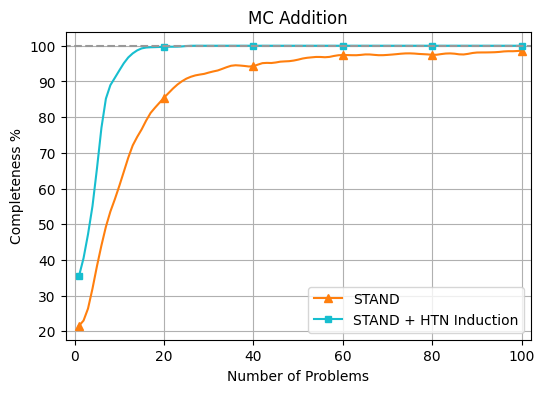

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40, 'label': 'STAND + HTN Induction', 'color': '#17becf', 'marker_props': {'marker': 's', 'markersize': 4, 'markevery': [0, 19, 39, 59, 79, -1]}}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


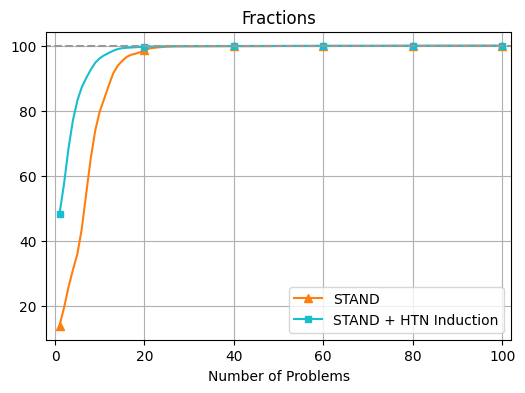

In [42]:

mc_proc_conds = {("mc", "stand", False, False) : {"n_prob": 100, "reps" : 40},
                 ("mc", "stand", True, False) : {"n_prob": 100, "reps" : 40,
                                           "label" : "STAND + HTN Induction", "color" : colors[9],
                                           "marker_props" : {"marker" : "s", "markersize" : 4, "markevery" : [0,19,39,59,79, -1]},
                }}

frac_proc_conds = {("frac", "stand", False, False) : {"n_prob": 100, "reps" : 40},
                   ("frac", "stand", True, False) : {"n_prob": 100, "reps" : 40, 
                                             "label" : "STAND + HTN Induction", "color" : colors[9],
                                             "marker_props" : {"marker" : "s", "markersize" : 4, "markevery" : [0,19,39,59,79, -1]},
                }}

plot_stat(mc_proc_conds, "completeness", 0, "MC Addition", h_line=100, save_name="mc_proc_compl", y_label="Completeness %") 
plot_stat(frac_proc_conds, "completeness", 0, "Fractions", h_line=100, save_name="frac_proc_compl")  



{'n_prob': 100, 'reps': 40, 'label': 'STAND + HTN Induction', 'color': '#17becf', 'marker_props': {'marker': 's', 'markersize': 4, 'markevery': [0, 19, 39, 59, 79, -1]}}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


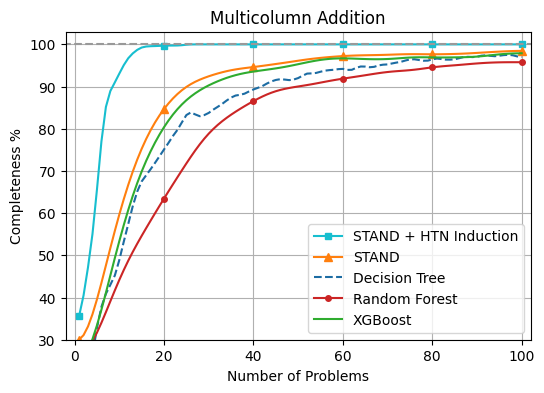

{'n_prob': 100, 'reps': 40, 'label': 'STAND + HTN Induction', 'color': '#17becf', 'marker_props': {'marker': 's', 'markersize': 4, 'markevery': [0, 19, 39, 59, 79, -1]}}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


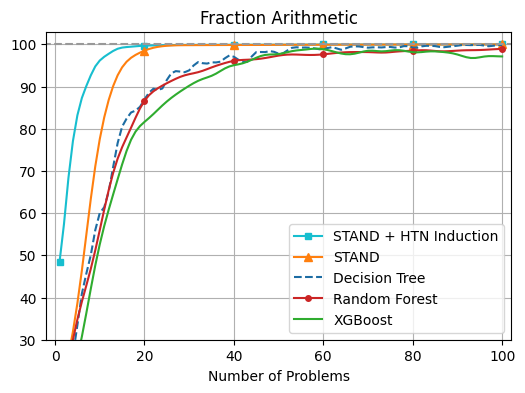

In [43]:
mc_all_conds = {
                 ("mc", "stand", True, False) : {"n_prob": 100, "reps" : 40,
                                           "label" : "STAND + HTN Induction", "color" : colors[9],
                                           "marker_props" : {"marker" : "s", "markersize" : 4, "markevery" : [0,19,39,59,79, -1]},
                },
                **mc_conditions,
}

frac_all_conds = {
                   ("frac", "stand", True, False) : {"n_prob": 100, "reps" : 40, 
                                             "label" : "STAND + HTN Induction", "color" : colors[9],
                                             "marker_props" : {"marker" : "s", "markersize" : 4, "markevery" : [0,19,39,59,79, -1]},                   
                },
                **frac_conditions,                                            
}

plot_stat(mc_all_conds, "completeness", 0, "Multicolumn Addition", y_lim=(30,103), h_line=100, save_name="mc_all_compl", y_label="Completeness %")
plot_stat(frac_all_conds, "completeness", 0, "Fraction Arithmetic", y_lim=(30,103), h_line=100, save_name="frac_all_compl")

In [44]:
# Process-Learning MC Addition

print_stats(mc_proc_conds, 0, "completeness", "Completeness prob=20", True, index=19)
print_stats(mc_proc_conds, 0, "completeness", "Completeness prob=50", True, index=49)
print_stats(mc_proc_conds, 0, "completeness", "Completeness prob=100", True, index=99)
print()
print_stats(mc_proc_conds, 1, "total_prod_monot", "Total Productive Monotonicity")
print_stats(mc_proc_conds, 1, "total_error_reocc", "Total Error Reoccurance", False)
print_stats(mc_proc_conds, 1, "total_FN_reocc", "Total Comission Reoccurance", False)
print_stats(mc_proc_conds, 1, "total_FP_reocc", "Total Omission Reoccurance", False)
print()
print_stats(mc_proc_conds, 1, ("total_precision",.9), "Total Precision @90%", True)
print_stats(mc_proc_conds, 1, ("total_precision",1.0), "Total Precision @100%", True)

Completeness prob=20:
  stand: 85.76%
  stand-proc: 99.72%
Completeness prob=50:
  stand: 95.89%
  stand-proc: 100.00%
Completeness prob=100:
  stand: 98.71%
  stand-proc: 100.00%

Total Productive Monotonicity:
  stand: 56.74%
  stand-proc: 60.92%
Total Error Reoccurance:
  stand: 0.53%
  stand-proc: 0.15%
Total Comission Reoccurance:
  stand: 0.86%
  stand-proc: 0.14%
Total Omission Reoccurance:
  stand: 0.43%
  stand-proc: 0.15%

Total Precision @90%:
  stand: 93.19%
  stand-proc: 63.27%
Total Precision @100%:
  stand: 99.81%
  stand-proc: 90.14%


In [45]:
# Process-Learning Frac


print_stats(frac_proc_conds, 0, "completeness", "Completeness prob=20", True, index=19)
print_stats(frac_proc_conds, 0, "completeness", "Completeness prob=50", True, index=49)
print_stats(frac_proc_conds, 0, "completeness", "Completeness prob=100", True, index=99)
print()
print_stats(frac_proc_conds, 1, "total_prod_monot", "Total Productive Monotonicity")
print_stats(frac_proc_conds, 1, "total_error_reocc", "Total Error Reoccurance", False)
print_stats(frac_proc_conds, 1, "total_FN_reocc", "Total Comission Reoccurance", False)
print_stats(frac_proc_conds, 1, "total_FP_reocc", "Total Omission Reoccurance", False)
print()
print_stats(frac_proc_conds, 1, ("total_precision",.9), "Total Precision @90%", True)
print_stats(frac_proc_conds, 1, ("total_precision",1.0), "Total Precision @100%", True)


Completeness prob=20:
  stand: 98.72%
  stand-proc: 99.69%
Completeness prob=50:
  stand: 99.91%
  stand-proc: 99.94%
Completeness prob=100:
  stand: 99.99%
  stand-proc: 99.99%

Total Productive Monotonicity:
  stand: 79.61%
  stand-proc: 70.73%
Total Error Reoccurance:
  stand: 0.05%
  stand-proc: 0.06%
Total Comission Reoccurance:
  stand: 0.08%
  stand-proc: 0.06%
Total Omission Reoccurance:
  stand: 0.04%
  stand-proc: 0.06%

Total Precision @90%:
  stand: 95.70%
  stand-proc: 71.08%
Total Precision @100%:
  stand: 100.00%
  stand-proc: 100.00%


{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


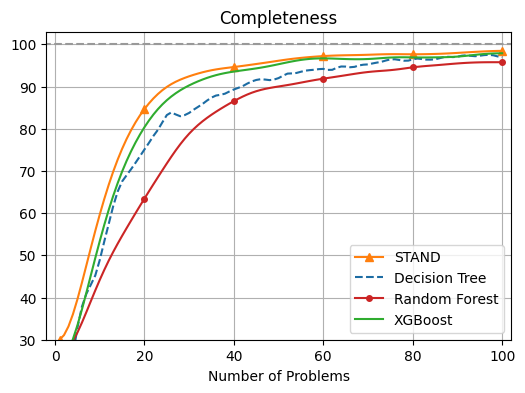

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


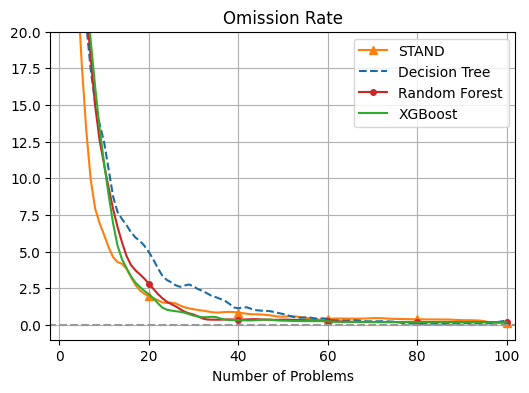

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


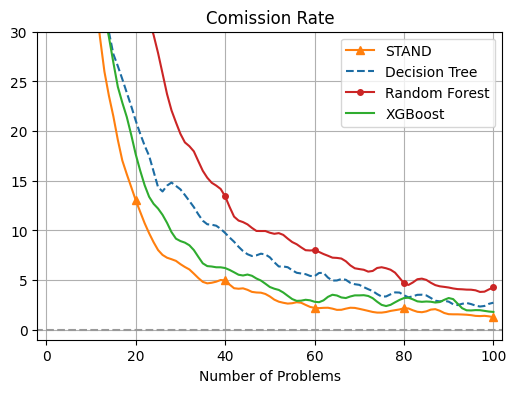

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


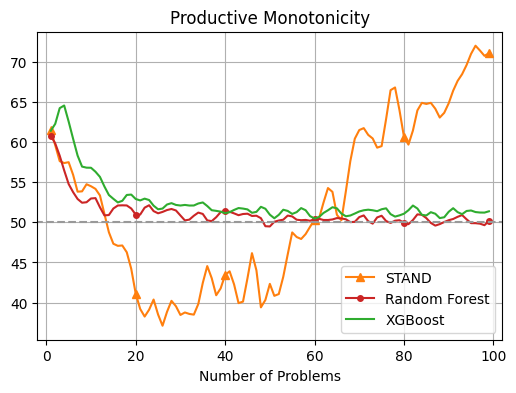

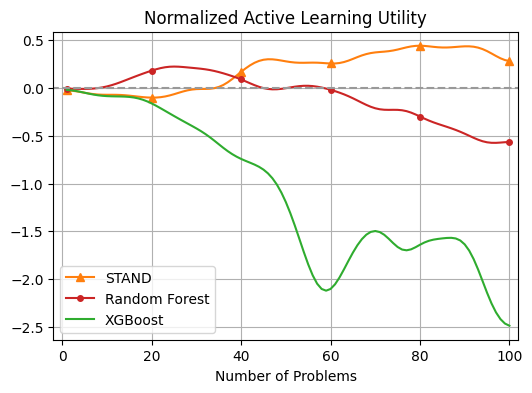

In [46]:
plot_stat(mc_conditions, "completeness", 0, "Completeness", y_lim=(30,103), h_line=100)
#plot_stat(mc_conditions, "step_score", 0, "Step Score")
plot_stat(mc_conditions, "omission_rate", 0, "Omission Rate", y_lim=(-1,20), h_line=0)
plot_stat(mc_conditions, "comission_rate", 0, "Comission Rate", y_lim=(-1,30), h_line=0)

plot_stat(mc_conditions, "prod_monot", 1, "Productive Monotonicity", skip=['decision_tree'], h_line=50)
#plot_stat(mc_conditions, "FP_reocc", 1, "Commission Reoccurance")
#plot_stat(mc_conditions, "FN_reocc", 1, "Ommission Reoccurance")
#plot_stat(mc_conditions, ('precision', .9), 1, "Precision @ 90%")
#plot_stat(mc_conditions, ('precision', 1.0), 1, "Precision @ 100%")

plot_diff(mc_conditions, mc_conditions_active, "completeness", 0, "Normalized Active Learning Utility", h_line=0) 



{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


/tmp/ipykernel_7570/2809534444.py:8: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


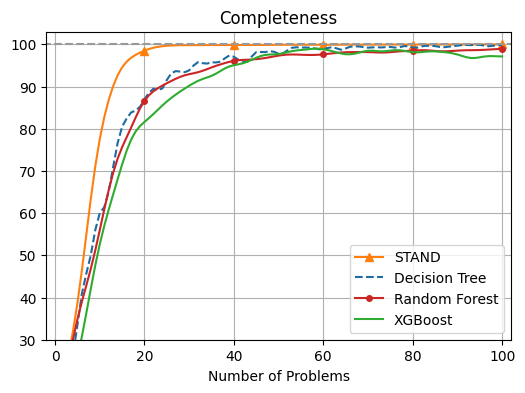

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


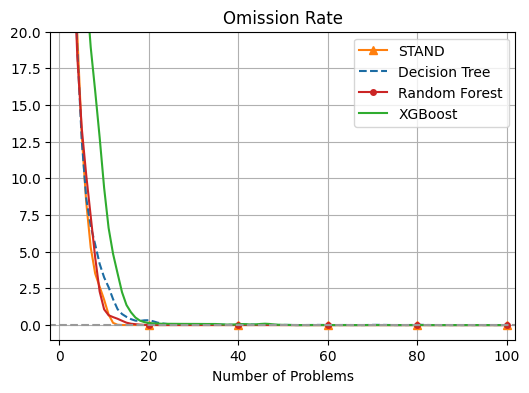

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


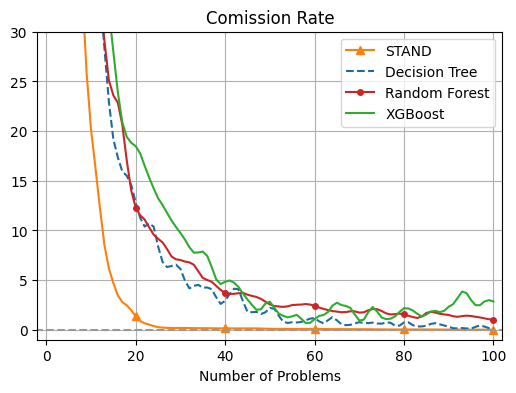

{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}
{'n_prob': 100, 'reps': 40}


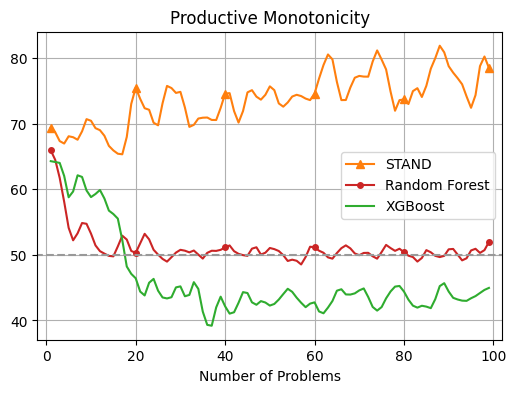

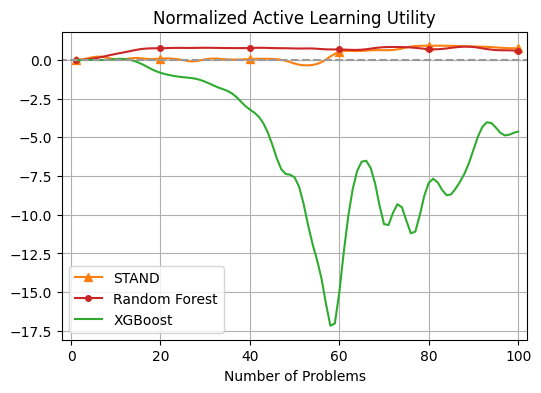

In [47]:
plot_stat(frac_conditions, "completeness", 0, "Completeness", y_lim=(30,103), h_line=100)
#plot_stat(frac_conditions, "step_score", 0, "Step Score")
plot_stat(frac_conditions, "omission_rate", 0, "Omission Rate", y_lim=(-1,20), h_line=0)
plot_stat(frac_conditions, "comission_rate", 0, "Comission Rate", y_lim=(-1,30), h_line=0)

plot_stat(frac_conditions, "prod_monot", 1, "Productive Monotonicity", skip=['decision_tree'], h_line=50)
#plot_stat(frac_conditions, "FP_reocc", 1, "Commission Reoccurance")
#plot_stat(frac_conditions, "FN_reocc", 1, "Ommission Reoccurance")
#plot_stat(frac_conditions, ('precision', .9), 1, "Precision @ 90%")
#lot_stat(frac_conditions, ('precision', 1.0), 1, "Precision @ 100%")
plot_diff(frac_conditions, frac_conditions_active, "completeness", 0, "Normalized Active Learning Utility", h_line=0) 

## Fit Time

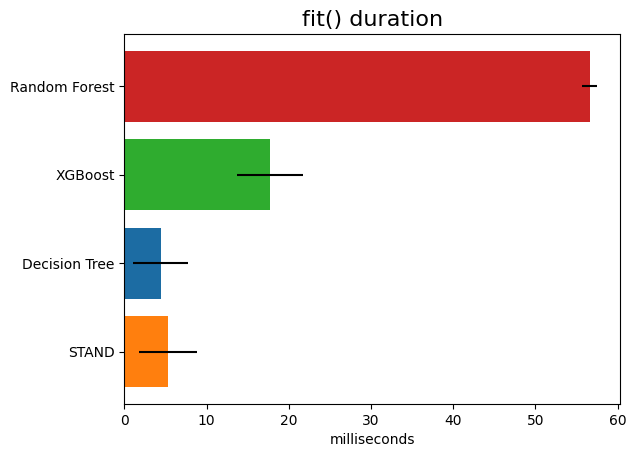

In [48]:
fit_times = {
    "stand" :         {"avg" : 5.3,   "std" : 3.539},
    "decision_tree" : {"avg" : 4.424, "std" : 3.327},
    "xg_boost" :      {"avg" : 17.735, "std" : 3.974},
    "random_forest" : {"avg" : 56.588, "std" : 0.876},
    
}

fig, ax = plt.subplots()

y_pos = np.arange(len(fit_times))
avgs = [v['avg'] for v in fit_times.values()]
stds = [v['std'] for v in fit_times.values()]

ax.barh(y_pos, avgs, xerr=stds, align='center', color=[cond_colors[k] for k in fit_times])
ax.set_yticks(y_pos, labels=[cond_labels[k] for k in fit_times])
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('milliseconds')
ax.set_title('fit() duration', fontsize=16)
plt.savefig(f"plots/fit_times.png", bbox_inches='tight')
plt.savefig(f"plots/fit_times.pdf", bbox_inches='tight', format='pdf')
plt.show()

## Predict Time

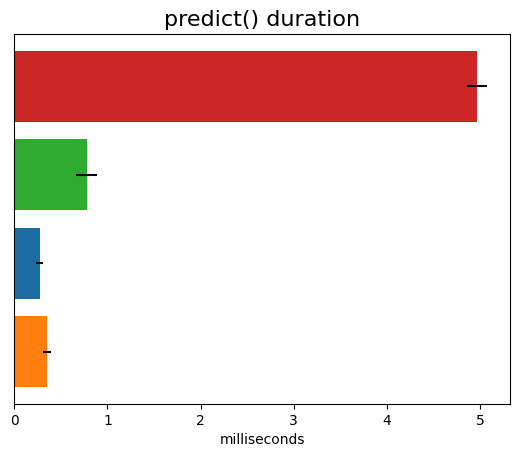

In [49]:
predict_times = {
    "stand" :         {"avg" : 0.355, "std" : 0.043},
    "decision_tree" : {"avg" : 0.273, "std" : 0.038},
    "xg_boost" :      {"avg" : 0.775, "std" : 0.112},
    "random_forest" : {"avg" : 4.969, "std" : 0.104},
    
}

fig, ax = plt.subplots()

y_pos = np.arange(len(predict_times))
avgs = [v['avg'] for v in predict_times.values()]
stds = [v['std'] for v in predict_times.values()]

ax.barh(y_pos, avgs, xerr=stds, align='center', color=[cond_colors[k] for k in predict_times])
ax.set_yticks(y_pos, labels=[cond_labels[k] for k in predict_times])

#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('milliseconds')
ax.set_title('predict() duration',fontsize=16)

plt.savefig(f"plots/predict_times.png", bbox_inches='tight')
plt.savefig(f"plots/predict_times.pdf", bbox_inches='tight', format='pdf')
ax.yaxis.set_visible(False)
plt.savefig(f"plots/predict_times_no_label.png", bbox_inches='tight')
plt.savefig(f"plots/predict_times_no_label.pdf", bbox_inches='tight', format='pdf')
plt.show()

In [50]:
def py_setitem(size):
    l = [0]*size
    for i in range(size):
        l[i] = i
    return l

def np_setitem(size):
    l = np.zeros(size)
    for i in range(size):
        l[i] = i
    return l

def py_getitem(size):
    l = [0]*size
    s = 0
    for i in range(size):
        s = l[i]
    return s
        
def np_getitem(size):
    l = np.zeros(size)
    s = 0
    for i in range(size):
        s = l[i]
    return s 
%timeit py_setitem(100000)
%timeit np_setitem(100000)
%timeit py_getitem(100000)
%timeit np_getitem(100000)

2.65 ms ± 68.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.96 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.3 ms ± 37.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.48 ms ± 191 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
from numba import njit, types, i8
from numba.typed import List
from numba.types import ListType

@njit(types.void(ListType(i8), i8))
def append_it(lst, other):
    lst.append(other)

append_it_ep = append_it.overloads[(ListType(i8), i8)].entry_point

def nb_append(size):
    l = List()
    for i in range(size):
        l.append(i)
    return l

def nb_append_custom(size):
    l = List.empty_list(i8)
    for i in range(size):
        append_it(l, i)
    return l

def nb_append_custom_ep(size):
    l = List.empty_list(i8)
    for i in range(size):
        append_it_ep(l, i)
    return l

def py_append(size):
    l = []
    for i in range(size):
        l.append(i)
    return l

%timeit py_append(100000)
%timeit nb_append(100000)
%timeit nb_append_custom(100000)
%timeit nb_append_custom_ep(100000)


3.58 ms ± 87.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
114 ms ± 3.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
102 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
48.8 ms ± 536 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
from training import train_or_load_rep
for i in range(20):
    stats, _, _  = train_or_load_rep("mc", "stand", False, False, 100, i)
    print(i, stats['completeness'][-1])

for i in range(20):
    stats, _, _  = train_or_load_rep("mc", "stand", False, True, 100, i)
    print(i, stats['completeness'][-1])


SKIP REP:  0
0 1.0
SKIP REP:  1
1 1.0
SKIP REP:  2
2 0.9718875502008032
SKIP REP:  3
3 0.9585006693440429
SKIP REP:  4
4 0.9973226238286479
SKIP REP:  5
5 1.0
SKIP REP:  6
6 1.0
SKIP REP:  7
7 0.9491298527443106
SKIP REP:  8
8 0.9477911646586346
SKIP REP:  9
9 0.9866131191432396
SKIP REP:  10
10 1.0
SKIP REP:  11
11 0.9973226238286479
SKIP REP:  12
12 0.9919678714859438
SKIP REP:  13
13 1.0
SKIP REP:  14
14 0.9919678714859438
SKIP REP:  15
15 0.9852744310575636
SKIP REP:  16
16 0.9692101740294511
SKIP REP:  17
17 1.0
SKIP REP:  18
18 0.9585006693440429
SKIP REP:  19
19 1.0
SKIP REP:  0
0 1.0
SKIP REP:  1
1 1.0
SKIP REP:  2
2 1.0
SKIP REP:  3
3 0.9625167336010709
SKIP REP:  4
4 1.0
SKIP REP:  5
5 0.9892904953145917
SKIP REP:  6
6 0.9759036144578314
SKIP REP:  7
7 1.0
SKIP REP:  8
8 0.9892904953145917
SKIP REP:  9
9 0.9759036144578314
SKIP REP:  10
10 1.0
SKIP REP:  11
11 0.9946452476572959
SKIP REP:  12
12 0.9919678714859438
SKIP REP:  13
13 0.9919678714859438
SKIP REP:  14
14 1.0
SKIP 

In [53]:
from training import load_rep
import numpy as np
n_100 = 0
for i in range(40):
    tup = load_rep("frac", "xg_boost", False, False, 100, i)
    if(tup is not None):
        stats, _, _ = tup
        compl = stats['completeness']
        #print(i, np.max(compl[10:30]), np.argmax(compl[10:30])+10, compl[-1])
        print(i, np.max(compl[10]), np.argmax(compl[10:30])+10, compl[-1])
        if(compl[-1] == 1.0):
            n_100 += 1
    else:
        print(i, None)

print(f"{n_100}/{40}")

0 0.2338362068965517 24 0.8793103448275862
1 0.35560344827586204 21 1.0
2 0.10560344827586207 24 1.0
3 0.7586206896551724 19 1.0
4 0.28448275862068967 29 1.0
5 0.9040948275862069 28 1.0
6 0.6745689655172413 24 1.0
7 0.5538793103448276 24 0.9730603448275862
8 0.2521551724137931 25 0.8577586206896551
9 0.7338362068965517 26 0.9105603448275862
10 0.6443965517241379 28 1.0
11 0.6443965517241379 28 1.0
12 0.8243534482758621 28 1.0
13 0.16379310344827586 28 0.9741379310344828
14 0.16918103448275862 21 1.0
15 0.32112068965517243 29 1.0
16 0.7974137931034483 19 1.0
17 0.677801724137931 23 1.0
18 0.6045258620689655 19 0.9709051724137931
19 0.7219827586206896 16 0.8318965517241379
20 0.26939655172413796 15 0.9730603448275862
21 0.6088362068965517 28 1.0
22 0.9019396551724138 27 1.0
23 0.7887931034482759 24 1.0
24 0.7984913793103449 29 1.0
25 0.7866379310344828 29 0.9946120689655172
26 0.6875 26 1.0
27 0.7510775862068966 28 0.9741379310344828
28 0.6799568965517241 12 0.8081896551724138
29 0.60668